In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import torch
from torch import nn as nn
from math import factorial
import random
import torch.nn.functional as F
import numpy as np
import seaborn as sn
import pandas as pd
import os 
from os.path import join
import glob
from math import factorial
ttype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
print(ttype)

# deep_iSITH is being used here, not deep_sith
from isith import iSITH
from tqdm.notebook import tqdm
import pickle
sn.set_context("poster")

<class 'torch.cuda.FloatTensor'>


In [73]:
test_isith = iSITH(tau_min=1.0, tau_max=500, ntau=200, buff_max=500, ttype=ttype, g=0).cuda()
test_input = ttype([1,0,0,0,0,0,0,1,1,1,1,0,0,0,0]).reshape(1,1,1,-1, 1)

# setup testing signals

In [74]:
repeats = 1
test_input1 = test_input.repeat(1,1,1,1,repeats).view(1,1,1,-1)
print(test_input1.shape)

torch.Size([1, 1, 1, 15])


In [75]:

repeats = 2
test_input2 = test_input.repeat(1,1,1,1,repeats).view(1,1,1,-1)
print(test_input2.shape)

torch.Size([1, 1, 1, 30])


# run signals

In [76]:
out1 = test_isith(test_input1[:, :, :, :])
print(out1.shape)

torch.Size([1, 200, 1, 15])


In [77]:
out2 = test_isith(test_input2[:, :, :, :])
print(out2.shape)

torch.Size([1, 200, 1, 30])


# plot output

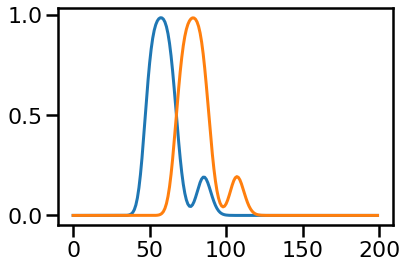

In [78]:
plt.plot(out1[0, :, 0, -1].detach().cpu());
plt.plot(out2[0, :, 0, -1].detach().cpu());

# Filter visualizations

In [79]:
test_isith.filters.shape


torch.Size([200, 1, 1, 500])

In [80]:
inp = test_input1
print(inp.shape)

torch.Size([1, 1, 1, 15])


In [81]:
out = torch.conv2d(inp, test_isith.filters[:, :, :, :], padding=[0, test_isith.filters.shape[-1]])
print(out.shape)

torch.Size([1, 200, 1, 516])


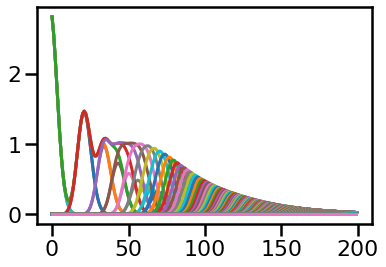

In [72]:
plt.plot(out.detach().cpu()[0, :, 0, :]);

In [85]:
(out.detach().cpu()[0, :, 0, 0] - out.detach().cpu()[0, :, 0, 1]).sum()

tensor(0.)